In [1]:
import torch
from model.st_unet import *
from model.train_eval import *
import copy
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
import h5py
from postprocessing.save_results import *
from postprocessing.plot_results import *
from postprocessing.metrics import single_roc_curve
from pathlib import Path
import pandas as pd
from matplotlib.patches import Patch

In [2]:
### check if cuda is available

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f"Using {device}.")

Using cuda.


In [10]:
### import data

def load_with_hdf5(name):
    """
    Load tensor data from HDF5 with gzip compression
    """
    with h5py.File(f"data/{name}.h5", "r") as f:
        loaded_features = torch.from_numpy(f["features"][:])
        loaded_labels = torch.from_numpy(f["labels"][:])
    return TensorDataset(loaded_features, loaded_labels)

train_set = load_with_hdf5("train_set_prep")
val_set = load_with_hdf5("val_set_prep")
test_set = load_with_hdf5("test_set_prep")


In [24]:
# Load model Antonio

model_filename = f"model/models_trained/Antonio_UNet3D_spatial_bloss_month3_4dwns_8ihiddim_3ker_maxpool_0.05ilr_15step_0.75gamma_16batch_100epochs_0.5wthr.pth"

n_channels = train_set[0][0].shape[0]
n_classes = 1 # ?
init_hid_dim = 8
kernel_size = 3
pooling = 'max'

#initialize model
model = UNet3D(n_channels=n_channels,
               n_classes=n_classes,
               init_hid_dim=init_hid_dim,
               kernel_size=kernel_size,
               pooling=pooling,
               bilinear=False,
               drop_channels=False)

# Load model state dictionary
model.load_state_dict(torch.load(model_filename))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print("Model loaded successfully!")


Model loaded successfully!


In [25]:
# Load losses and metrics
# losses_file = "metrics_and_losses/spatial_1_hid8_kernel3_max_lr0.05_step15_gamma0.75_bs16_epochs10_wt0.5_losses.csv"

# df_losses = pd.read_csv(losses_file)


# print("Losses loaded successfully!")

metrics_file = "model/losses_metrics/Antonio_UNet3D_spatial_losses&metrics_month3_4dwns_8ihiddim_3ker_maxpool_0.05ilr_15step_0.75gamma_16batch_100epochs_0.5wthr.csv"

df_metrics = pd.read_csv(metrics_file)
train_losses = df_metrics["Training loss"].tolist()
val_losses = df_metrics["Validation loss"].tolist()
accuracies = df_metrics["Accuracy"].tolist()
precisions = df_metrics["Precision"].tolist()
recalls = df_metrics["Recall"].tolist()
f1_scores = df_metrics["F1-score"].tolist()
csi_scores = df_metrics["CSI-score"].tolist()

metrics = [accuracies, precisions, recalls, f1_scores, csi_scores]
print("Metrics loaded successfully!")

Metrics loaded successfully!


ATTENTION: the argument `save_name` is not specified: the plot is not saved.


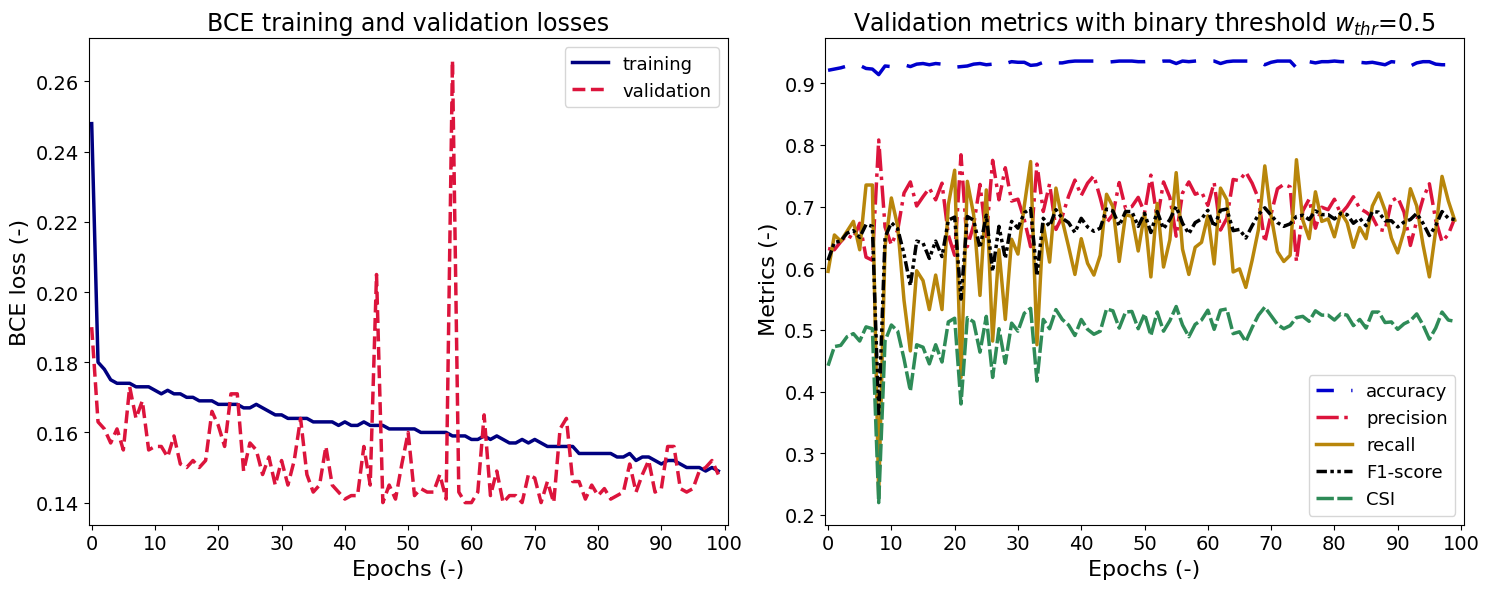

In [26]:
plot_losses_metrics(train_losses, val_losses, metrics, model, loss_f="BCE")

In [27]:
def show_results_3d(sample_img, dataset, model, water_threshold=0.5, device='cuda:0', save_img=False, title=None):
    """
    Visualize the target, prediction, and misclassification map with an optional title.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.colors import ListedColormap

    # Ensure the input has the correct shape (N, C, T, H, W)
    input_img = dataset[sample_img][0].unsqueeze(0).to(device)  # Add batch dimension
    target_img = dataset[sample_img][1].cpu()

    # Get model prediction
    with torch.no_grad():
        prediction = model(input_img).detach().cpu()  # Shape: (N, C, H, W)

    # Binary thresholding
    prediction_binary = (prediction >= water_threshold).float()

    # Calculate misclassification map
    diff = prediction_binary.squeeze(0).squeeze(0) - target_img  # Remove batch and channel dims

    # Set up figure
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))

    # Custom colormaps
    grey_cmap = ListedColormap(['palegoldenrod', 'navy'])  # For binary river images
    diff_cmap = ListedColormap(['red', 'white', 'green'])
    grey_diff_cmap = ListedColormap(['black', 'white'])

    # Plot target
    ax[0].imshow(target_img, cmap=grey_cmap, vmin=0)
    ax[0].set_title('Target', fontsize=13)
    ax[0].set_xlabel('Width (km)', fontsize=12)
    ax[0].set_ylabel('Length (km)', fontsize=12)

    # Plot prediction
    ax[1].imshow(prediction_binary.squeeze(0).squeeze(0), cmap=grey_cmap)
    ax[1].set_title('Prediction', fontsize=13)
    ax[1].set_xlabel('Width (km)', fontsize=12)

    # Plot misclassification map
    ax[2].imshow(diff, cmap=diff_cmap, vmin=-1, vmax=1)
    ax[2].imshow(target_img, cmap=grey_diff_cmap, vmin=0, alpha=0.2)
    ax[2].set_title('Difference (Prediction - Target)', fontsize=13)
    ax[2].set_xlabel('Width (km)', fontsize=12)

    # Add optional title for the entire figure
    if title:
        fig.suptitle(title, fontsize=16, fontweight='bold')

    # Adjust layout
    fig.subplots_adjust(wspace=0.3, top=0.85 if title else 0.9)
    plt.tight_layout()

    # Save or show the plot
    if save_img:
        plt.savefig(f'output_{sample_img}.png', bbox_inches='tight', dpi=1000)
        plt.close(fig)
    else:
        plt.show()

    return None


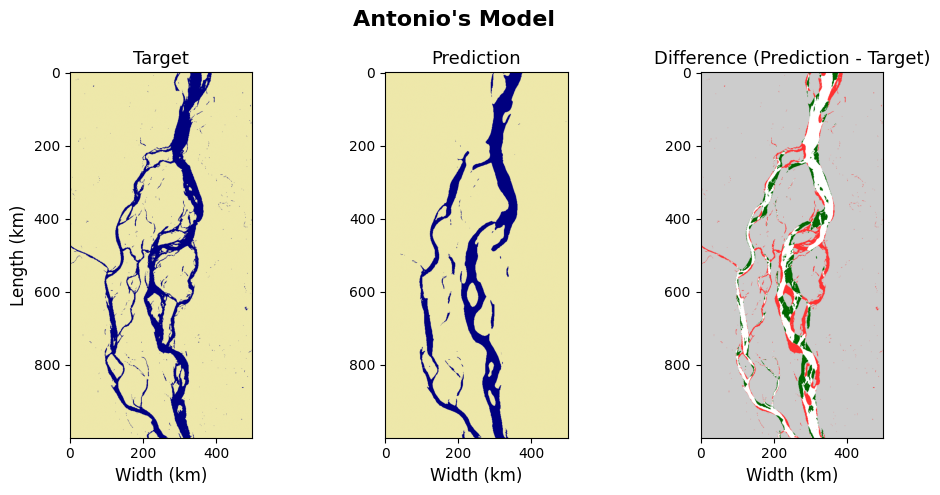

In [28]:
sample_index = 11 # Example test sample index
show_results_3d(sample_index, test_set, model, title="Antonio's Model")